In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install psutil

逻辑核心数: 8
物理核心数: 4
CPU使用率: [2.0, 1.0, 11.1, 1.0, 1.0, 8.0, 2.0, 1.0]
CPU当前频率: 2199.998 MHz
CPU最大频率: 0.0 MHz
CPU最小频率: 0.0 MHz


In [ ]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 26.3 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp


In [ ]:
gp.Model()

Restricted license - for non-production use only - expires 2025-11-24


<gurobi.Model Continuous instance Unnamed: 0 constrs, 0 vars, No parameter changes>

In [ ]:
params = {
"WLSACCESSID": '9cc3b880-4451-4656-90e7-170df1dbc7b1',
"WLSSECRET": '631d4caf-e8c4-40c5-9672-a18509c0440b',
"LICENSEID": 2475817,
}
env = gp.Env(params=params)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475817
Academic license 2475817 - for non-commercial use only - registered to ji___@student.kuleuven.be


In [ ]:
env.dispose()

In [ ]:
!pip install geopy
!pip install shapely

import numpy as np
import pandas as pd
from geopy import distance
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

In [ ]:
def random_generate_candidate_AED_sites(points,M=100):
    '''
    randomly generate candidate AED locations
    :param points:
    :param M:
    :return:
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])



def distance_matrix_geo(x,y,unit='km'):
    '''
    compute distance matrix given longitude and latitude data
    unoptimized version, can be very slow!!
    :param x:
    :param y:
    :param unit: measure unit e.g. m, km , miles?
    :return:
    '''
    x = np.asarray(x)
    y = np.asarray(y)
    m,_ = x.shape
    n, _ = y.shape

    result = np.empty((m,n),dtype=float)
    for i, cord_x in enumerate(x):
        for j, cord_y in enumerate(y):
            d = distance.great_circle(cord_x,cord_y)
            result[i][j] = getattr(d,unit)
    return result


def mclp(points, K, radius, M, w=None):
    '''
    Maximal coverage location problem for AED placement
    :param points: Intervention locations
    :param K: Number of selected AED locations
    :param radius: range that can be covered by one AED device
    :param M: Number of candidate AED locations
    :param W: Weight, could be waiting time (T3-T0)?
    :return: optimized AED location,
             optimal value for obective function (number of interventions covered by optimized AED placement)
             number of covered cases
             coverage rate
             distance matrix
             (randomly generated) candidate AED placement sites

    '''
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = random_generate_candidate_AED_sites(points, M)
    J = sites.shape[0]
    I = points.shape[0]
    DM = distance_matrix_geo(points, sites)
    D = DM
    mask1 = D <= radius
    D[mask1] = 1
    D[~mask1] = 0
    # Build model
    m = Model(env=env)
    # Add variables
    x = {}
    y = {}
    for i in range(I):
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i] == 1)[0]) >= y[i])
    if w is None:
        m.setObjective(quicksum(y[i] for i in range(I)), GRB.MAXIMIZE)
    else:
        m.setObjective(quicksum(y[i]*w[i] for i in range(I)), GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end - start))
    print('  Optimal coverage points: %g' % m.objVal)

    solution = []
    covered_intervention_index = []
    covered_intervention_cases = 0

    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x == 1 and v.varName[0] == "y":
                covered_intervention_cases += 1
                covered_intervention_index.append(int(v.VarName[1:]))
            if v.x == 1 and v.varName[0] == "x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites, m.objVal, int(covered_intervention_cases), int(covered_intervention_cases)/I, covered_intervention_index, DM, sites

In [ ]:
def mean_nearst_AED_distance(interventions_latlon,AED_latlon):
  dm = distance_matrix_geo(interventions_latlon,AED_latlon,'meters')
  dm_min = np.min(dm,axis=1)
  return np.mean(dm_min)


In [ ]:
interventions_within_aedhop = pd.read_csv('/content/drive/MyDrive/Datathon_Data/Processed/intervention_within_aed_hospital.csv',encoding='utf-8')
interventions_without_aedhop = pd.read_csv('/content/drive/MyDrive/Datathon_Data/Processed/intervention_without_aed_hospital.csv',encoding='utf-8')
interventions = pd.concat([interventions_within_aedhop,interventions_without_aedhop],axis=0)
interventions

mission_id     t0_date  duration_t3-t0 eventtype_code eventlevel  \
0     21221540239  2022-06-03       50.116667           P003         N1   
1     21221540239  2022-06-03             NaN           P003         N1   
2     21221540463  2022-06-03       28.583333           P003         N1   
3     21221540463  2022-06-03       28.583333           P003         N1   
4     21221540548  2022-07-16             NaN           P003         N1   
...           ...         ...             ...            ...        ...   
5810  50221900691  2022-07-09        4.936883           P003         N2   
5811  50221900691  2022-07-09       17.369467           P003         N2   
5812  50221910287  2022-07-10        7.557850           P003         N1   
5813  50221910483  2022-07-10       15.029300           P003         N1   
5814  50221910483  2022-07-10       15.822567           P003         N1   

                         province  postalcode_intervention        lat  \
0     Province du Brabant flamand                      NaN  50.842169   
1     Province du Brabant flamand                      NaN  50.842169   
2     Province du Brabant flamand                      NaN  50.810332   
3     Province du Brabant flamand                      NaN  50.810332   
4     Province du Brabant flamand                      NaN  50.862980   
...                           ...                      ...        ...   
5810          Province de Hainaut                      NaN  50.467630   
5811          Province de Hainaut                      NaN  50.467630   
5812          Province de Hainaut                      NaN  50.038540   
5813          Province de Hainaut                      NaN  50.535940   
5814          Province de Hainaut                      NaN  50.535940   

           lon abandon_reason  
0     4.469844            NaN  
1     4.469844            NaN  
2     4.232565            NaN  
3     4.232565            NaN  
4     4.690620            NaN  
...        ...            ...  
5810  4.104320            NaN  
5811  4.104320            NaN  
5812  4.263650      Overleden  
5813  4.246450      Overleden  
5814  4.246450            NaN  

[12286 rows x 10 columns]

In [ ]:
interventions['province'].unique()

array(['Province du Brabant flamand', 'Région de Bruxelles-Capitale', nan,
       'Province de Flandre occidentale', 'Province de Flandre orientale',
       'Province de Hainaut', 'Province de Namur', 'False',
       'Province de Luxembourg', 'Province du Brabant wallon',
       'Province de Limbourg', 'Province d’Anvers'], dtype=object)

In [ ]:
interventions = interventions[(interventions['province']=='Province du Brabant flamand') | (interventions['province']=='Région de Bruxelles-Capitale')]
interventions = interventions.dropna(subset=['duration_t3-t0'])
interventions = interventions.dropna(subset=['lat'])
interventions = interventions.dropna(subset=['lon'])
#interventions = interventions.drop_duplicates(subset=['lat','lon'])
interventions

mission_id     t0_date  duration_t3-t0 eventtype_code eventlevel  \
0     21221540239  2022-06-03       50.116667           P003         N1   
2     21221540463  2022-06-03       28.583333           P003         N1   
3     21221540463  2022-06-03       28.583333           P003         N1   
6     21221560159  2022-06-05       18.466667           P003         N1   
8     21221560745  2022-06-05        9.933333           P003         N1   
...           ...         ...             ...            ...        ...   
2493  20223400163  2022-12-06        9.383939           P003         N1   
5632  22223120052  2022-11-08       13.666983           P003         N1   
5633  22223120052  2022-11-08       21.950750           P003         N1   
5700  22230750078  2023-03-16        9.483133           P003         N1   
5701  22230750078  2023-03-16       15.456117           P003         N1   

                         province  postalcode_intervention        lat  \
0     Province du Brabant flamand                      NaN  50.842169   
2     Province du Brabant flamand                      NaN  50.810332   
3     Province du Brabant flamand                      NaN  50.810332   
6     Province du Brabant flamand                      NaN  50.908946   
8     Province du Brabant flamand                      NaN  50.864708   
...                           ...                      ...        ...   
2493  Province du Brabant flamand                   1780.0  50.910190   
5632  Province du Brabant flamand                      NaN  50.753580   
5633  Province du Brabant flamand                      NaN  50.753580   
5700  Province du Brabant flamand                      NaN  50.715910   
5701  Province du Brabant flamand                      NaN  50.715910   

           lon abandon_reason  
0     4.469844            NaN  
2     4.232565            NaN  
3     4.232565            NaN  
6     4.203203            NaN  
8     4.442090            NaN  
...        ...            ...  
2493  4.296190            NaN  
5632  4.955580            NaN  
5633  4.955580            NaN  
5700  4.108900      Overleden  
5701  4.108900            NaN  

[1568 rows x 10 columns]

In [ ]:
interventions = interventions[interventions['duration_t3-t0'] < 200] #drop extreme values

## `Model Configuration`

In [ ]:
points = np.array(interventions[['lat','lon']])
K = 1230 #number of selected AEDs
radius = 0.2   #covered area of AED, a circle with radius 200m
M = 20000  #number of candidate AED locations
W = np.array(interventions['duration_t3-t0']) #weigts, T3-T0

In [ ]:
opt_sites, f, c, cr,covered_intervention_index, dm, candiate_AED_sites = mclp(points, K, radius, M, W)
cr

----- Configurations -----
  Number of points 1250
  K 1230
  Radius 0.2
  M 20000
----- Output -----
  Running time : 332.9050302505493 seconds
  Optimal coverage points: 14761.4


0.644

In [ ]:
interventions = interventions.reset_index()
interventions.loc[covered_intervention_index]

index   mission_id     t0_date  duration_t3-t0 eventtype_code  \
1         2  21221540463  2022-06-03       28.583333           P003   
2         3  21221540463  2022-06-03       28.583333           P003   
4         8  21221560745  2022-06-05        9.933333           P003   
5         9  21221560745  2022-06-05        9.933333           P003   
6        10  21221580059  2022-06-07       11.200000           P003   
...     ...          ...         ...             ...            ...   
1232    838  21231500536  2023-05-30       13.466667           P003   
1237   2483  20222590086  2022-09-16       15.385819           P003   
1238   2484  20222590086  2022-09-16       10.747757           P003   
1244   2491  20222870114  2022-10-14       16.597666           P003   
1245   2493  20223400163  2022-12-06        9.383939           P003   

     eventlevel                      province  postalcode_intervention  \
1            N1   Province du Brabant flamand                      NaN   
2            N1   Province du Brabant flamand                      NaN   
4            N1   Province du Brabant flamand                      NaN   
5            N1   Province du Brabant flamand                      NaN   
6            N1   Province du Brabant flamand                      NaN   
...         ...                           ...                      ...   
1232         N1   Province du Brabant flamand                      NaN   
1237         N1  Région de Bruxelles-Capitale                   1150.0   
1238         N1  Région de Bruxelles-Capitale                   1150.0   
1244         N1  Région de Bruxelles-Capitale                   1150.0   
1245         N1   Province du Brabant flamand                   1780.0   

            lat       lon abandon_reason  
1     50.810332  4.232565            NaN  
2     50.810332  4.232565            NaN  
4     50.864708  4.442090            NaN  
5     50.864708  4.442090            NaN  
6     50.861866  4.708210            NaN  
...         ...       ...            ...  
1232  50.784685  4.499381            NaN  
1237  50.831260  4.464850            NaN  
1238  50.831260  4.464850      Overleden  
1244  50.827570  4.460970            NaN  
1245  50.910190  4.296190            NaN  

[805 rows x 11 columns]

In [ ]:
opt_sites

array([[50.91970112,  4.16891684],
       [50.9178007 ,  4.37332865],
       [51.00487227,  4.86499648],
       ...,
       [50.81489824,  4.16637656],
       [50.89128818,  4.44443447],
       [50.86295206,  4.26581413]])

In [ ]:
#compute mean nearest AED distance
mean_nearst_AED_distance(np.array(interventions[['lat','lon']]),opt_sites)

286.3542309939976

In [ ]:
all_opt_aedloc_MCLP_Bra = pd.DataFrame(dict(lat=list(opt_sites[:,0]),lon=list(opt_sites[:,1])))
all_opt_aedloc_MCLP_Bra.to_csv('/content/drive/MyDrive/Datathon_Data/Processed/all_opt_aedloc_MCLP_Brawithbru.csv',index=False)

In [ ]:
# number of covered intervention cases
c

500

In [ ]:
!pip install folium

In [ ]:
import time

In [ ]:
import folium

newlatlon = np.array(all_opt_aedloc_MCLP_Bra)

# 创建地图对象
m = folium.Map()

# 添加标记
for lat,lon in newlatlon:
    folium.Marker(location=[lat, lon], popup='Latitude: {}, Longitude: {}'.format(lat, lon), icon=folium.Icon(color='blue')).add_to(m)
for lat,lon in points:
    folium.Marker(location=[lat, lon], popup='Latitude: {}, Longitude: {}'.format(lat, lon), icon=folium.Icon(color='red')).add_to(m)
m

In [ ]:
new_aed_df = pd.read_csv('/content/drive/MyDrive/Datathon_Data/Processed/aed_df_with_province.csv',encoding='utf-8')
aed_bra = new_aed_df[new_aed_df['new_province']=='Province du Brabant flamand']
aed_bra

Unnamed: 0     id_x                         type           address  \
13             13     95.0                          NaN       Peperstraat   
20             20    111.0                          NaN        Hermeslaan   
27             27    167.0                          NaN      Vanhalstraat   
53             53    275.0                          NaN      Da Vincilaan   
63             63    318.0                          NaN  Interleuvenlaan    
...           ...      ...                          ...               ...   
15139       15139  16611.0  Appareil fixe-Vast apparaat        Torleylaan   
15146       15146  16617.0  Appareil fixe-Vast apparaat      Nijvelsebaan   
15159       15159  16628.0  Appareil fixe-Vast apparaat      Reppelsebaan   
15166       15166  16635.0  Appareil fixe-Vast apparaat       Astridlaan    
15170       15170  16639.0  Appareil fixe-Vast apparaat       Klaarstraat   

       number  postal_code     municipality                     province  \
13          2         3300           TIENEN  Province du Brabant flamand   
20          2         1831      MachelenBt)  Province du Brabant flamand   
27          1         1500            Halle  Province du Brabant flamand   
53         -1         1930         Zaventem  Province du Brabant flamand   
63         58         3001           Leuven  Province du Brabant flamand   
...       ...          ...              ...                          ...   
15139     100         1654        Huizingen  Province du Brabant flamand   
15146     190         3090         Overijse  Province du Brabant flamand   
15159      65         3294            Diest  Province du Brabant flamand   
15166      85         1970  Wezembeek-Oppem  Province du Brabant flamand   
15170     139         1745           Opwijk  Province du Brabant flamand   

                                                location   public available  \
13                                                   NaN        Y       NaN   
20                                                   NaN      NaN       NaN   
27                                                   NaN        y       NaN   
53                                                   NaN      NaN       NaN   
63                                                   NaN      NaN       NaN   
...                                                  ...      ...       ...   
15139  In kast in de inkomhal van het gebouw Wauwerin...  Non-Nee   Non-Nee   
15146                                  Achterkant buiten  Non-Nee   Non-Nee   
15159                                                      Oui-Ja   Non-Nee   
15166                            Buiten aan de cafetaria   Oui-Ja    Oui-Ja   
15170                        voetbalkantine Tesseskouter   Oui-Ja    Oui-Ja   

                                                   hours  \
13                                                   NaN   
20                                                   NaN   
27                                                   NaN   
53                                                   NaN   
63                                                   NaN   
...                                                  ...   
15139  Enkel beschikbaar tijdens de openingsuren van ...   
15146                                        07h30 - 18h   
15159                                                NaN   
15166                                                NaN   
15170                                                NaN   

                                            full_address  new_id     id_y  \
13          Peperstraat, 2, 3300, TIENEN, Vlaams-Brabant      14     95.0   
20      Hermeslaan, 2, 1831, MachelenBt), Vlaams-Brabant      21    111.0   
27          Vanhalstraat, 1, 1500, Halle, Vlaams-Brabant      28    167.0   
53         Da Vincilaan,  1930, Zaventem, Vlaams-Brabant      54    275.0   
63     Interleuvenlaan , 58, 3001, Leuven, Vlaams-Bra...      64    318.0   
...                                  

In [ ]:
# 创建地图对象
m2 = folium.Map()

# 添加标记
for lat,lon in np.array(aed_bra[['lat','lon']]):
    folium.Marker(location=[lat, lon], popup='Latitude: {}, Longitude: {}'.format(lat, lon), icon=folium.Icon(color='blue')).add_to(m2)
for lat,lon in points:
    folium.Marker(location=[lat, lon], popup='Latitude: {}, Longitude: {}'.format(lat, lon), icon=folium.Icon(color='red')).add_to(m2)
m2

## Additional AED Number - Mean Nearest AED Distance Plot / Sensitivity analysis

In [ ]:
num_candidate_AED_sites = 20000
candidate_AED_sites_sim = random_generate_candidate_AED_sites(np.array(interventions[['lat','lon']]),num_candidate_AED_sites)
dm_sim = distance_matrix_geo(np.array(interventions[['lat','lon']]),candidate_AED_sites_sim)
dm_sim.shape

(622, 20000)

In [ ]:
def mclp_adj(points, K, radius, distancematrix, candidate, w=None):
    '''
    Maximal coverage location problem for AED placement (adjusted version)
    :param points: Intervention locations
    :param K: Number of selected AED locations
    :param radius: range that can be covered by one AED device
    :param M: Number of candidate AED locations
    :param W: Weight, could be waiting time (T3-T0)?
    :return: optimized AED location,
             optimal value for obective function (number of interventions covered by optimized AED placement)
             number of covered cases
             coverage rate
             distance matrix
             (randomly generated) candidate AED placement sites

    '''
    # print('----- Configurations -----')
    # print('  Number of points %g' % points.shape[0])
    # print('  K %g' % K)
    # print('  Radius %g' % radius)
    #print('  M %g' % M)
    #start = time.time()
    sites = candidate
    J = sites.shape[0]
    I = points.shape[0]
    #DM = distance_matrix_geo(points, sites)
    D = distancematrix
    mask1 = D <= radius
    D[mask1] = 1
    D[~mask1] = 0
    # Build model
    m = Model(env=env)
    # Add variables
    x = {}
    y = {}
    for i in range(I):
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i] == 1)[0]) >= y[i])
    if w is None:
        m.setObjective(quicksum(y[i] for i in range(I)), GRB.MAXIMIZE)
    else:
        m.setObjective(quicksum(y[i]*w[i] for i in range(I)), GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    #end = time.time()
    # print('----- Output -----')
    # print('  Running time : %s seconds' % float(end - start))
    # print('  Optimal coverage points: %g' % m.objVal)

    solution = []
    covered_intervention_cases = 0
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x == 1 and v.varName[0] == "y":
                covered_intervention_cases += 1
            if v.x == 1 and v.varName[0] == "x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites, m.objVal, int(covered_intervention_cases), int(covered_intervention_cases)/I, D, sites

In [ ]:
#Configuration
int_points = np.array(interventions[['lat','lon']])
radius = 0.2   #covered area of AED, a circle with radius 200m
W = np.array(interventions['duration_t3-t0']) #weigts, T3-T0

#cr_values_ls = [] #coverage rate
mean_nearst_AED_distance_ls = [] #mean distance to nearest AED

start_K = 1230
end_K = 1600
K_sim_values = np.arange(start_K, end_K, 30)
for K_sim in K_sim_values:
  temp_opt_sites,_,_,temp_cr,_,_ = mclp_adj(int_points,K_sim,radius,dm_sim,candidate_AED_sites_sim,W)

  print(mean_nearst_AED_distance(int_points,temp_opt_sites))
  #print(K_sim)

300.4157495271831
690.9722247712062
295.7449824644919
664.1497512261278
289.86357237485413
637.6435850230647
285.5682757941556
616.4852634553265
283.65398620393756
607.3424575733649
282.07052764789154
603.7993161923376
277.24451132662824


In [ ]:
range(start_K, end_K, 10)

range(1230, 1400, 10)

In [ ]:
import matplotlib.pyplot as plt

# 给定的数据
data = [300.4157495271831, 690.9722247712062, 295.7449824644919, 664.1497512261278,
        289.86357237485413, 637.6435850230647, 285.5682757941556, 616.4852634553265,
        283.65398620393756, 607.3424575733649, 282.07052764789154, 603.7993161923376,
        277.24451132662824]

# 生成x轴数据（从1开始的整数序列）
x = range(1, len(data) + 1)

# 绘制折线图
plt.figure(figsize=(10, 5))  # 设置图形大小
plt.plot(x, data, marker='o', linestyle='-')  # 绘制折线图
plt.title('折线图')  # 设置标题
plt.xlabel('数据点编号')  # 设置x轴标签
plt.ylabel('数据值')  # 设置y轴标签
plt.grid(True)  # 显示网格线
plt.show()  # 显示图形

In [ ]:
arr = np.array([1, 2, 3, 4, 5])
list(np.where(arr>3)[0])

[3, 4]

##

In [ ]:
def covered_by_aed_index_andcr(interventions_latlon,AED_latlon):
  dm = distance_matrix_geo(interventions_latlon,AED_latlon,'meters')
  dm_min = np.min(dm,axis=1)
  return list(np.where(dm_min<=200)[0]), sum(dm_min<=200)/len(dm_min), sum(dm_min<=200)




#Configuration
#int_points = np.array(interventions[['lat','lon']])
radius = 0.2   #covered area of AED, a circle with radius 200m
W = np.array(interventions['duration_t3-t0']) #weigts, T3-T0

#cr_values_ls = [] #coverage rate
new_covered_aed_num = [] #mean distance to nearest AED

old_aed_df = pd.read_csv('/content/drive/MyDrive/Datathon_Data/Processed/aed_df_with_province.csv', encoding='utf-8')
old_aed_df = old_aed_df[(old_aed_df['new_province']=='Province du Brabant flamand') | (old_aed_df['new_province']=='Région de Bruxelles-Capitale')]
covered_by_old_aed_index, cr_old, covered_num_old = covered_by_aed_index_andcr(np.array(interventions[['lat','lon']]),np.array(old_aed_df[['lat','lon']]))
interventions_notcovered = interventions.loc[~interventions.index.isin(covered_by_old_aed_index)]

print(covered_num_old)



463


In [ ]:
interventions

mission_id     t0_date  duration_t3-t0 eventtype_code eventlevel  \
0     21221540239  2022-06-03       50.116667           P003         N1   
2     21221540463  2022-06-03       28.583333           P003         N1   
3     21221540463  2022-06-03       28.583333           P003         N1   
6     21221560159  2022-06-05       18.466667           P003         N1   
8     21221560745  2022-06-05        9.933333           P003         N1   
...           ...         ...             ...            ...        ...   
2493  20223400163  2022-12-06        9.383939           P003         N1   
5632  22223120052  2022-11-08       13.666983           P003         N1   
5633  22223120052  2022-11-08       21.950750           P003         N1   
5700  22230750078  2023-03-16        9.483133           P003         N1   
5701  22230750078  2023-03-16       15.456117           P003         N1   

                         province  postalcode_intervention        lat  \
0     Province du Brabant flamand                      NaN  50.842169   
2     Province du Brabant flamand                      NaN  50.810332   
3     Province du Brabant flamand                      NaN  50.810332   
6     Province du Brabant flamand                      NaN  50.908946   
8     Province du Brabant flamand                      NaN  50.864708   
...                           ...                      ...        ...   
2493  Province du Brabant flamand                   1780.0  50.910190   
5632  Province du Brabant flamand                      NaN  50.753580   
5633  Province du Brabant flamand                      NaN  50.753580   
5700  Province du Brabant flamand                      NaN  50.715910   
5701  Province du Brabant flamand                      NaN  50.715910   

           lon abandon_reason  
0     4.469844            NaN  
2     4.232565            NaN  
3     4.232565            NaN  
6     4.203203            NaN  
8     4.442090            NaN  
...        ...            ...  
2493  4.296190            NaN  
5632  4.955580            NaN  
5633  4.955580            NaN  
5700  4.108900      Overleden  
5701  4.108900            NaN  

[1250 rows x 10 columns]

In [ ]:
cr_old

0.3704

In [ ]:
interventions.shape

(1250, 10)

In [ ]:
interventions_notcovered

mission_id     t0_date  duration_t3-t0 eventtype_code eventlevel  \
0     21221540239  2022-06-03       50.116667           P003         N1   
2     21221540463  2022-06-03       28.583333           P003         N1   
3     21221540463  2022-06-03       28.583333           P003         N1   
6     21221560159  2022-06-05       18.466667           P003         N1   
8     21221560745  2022-06-05        9.933333           P003         N1   
...           ...         ...             ...            ...        ...   
2493  20223400163  2022-12-06        9.383939           P003         N1   
5632  22223120052  2022-11-08       13.666983           P003         N1   
5633  22223120052  2022-11-08       21.950750           P003         N1   
5700  22230750078  2023-03-16        9.483133           P003         N1   
5701  22230750078  2023-03-16       15.456117           P003         N1   

                         province  postalcode_intervention        lat  \
0     Province du Brabant flamand                      NaN  50.842169   
2     Province du Brabant flamand                      NaN  50.810332   
3     Province du Brabant flamand                      NaN  50.810332   
6     Province du Brabant flamand                      NaN  50.908946   
8     Province du Brabant flamand                      NaN  50.864708   
...                           ...                      ...        ...   
2493  Province du Brabant flamand                   1780.0  50.910190   
5632  Province du Brabant flamand                      NaN  50.753580   
5633  Province du Brabant flamand                      NaN  50.753580   
5700  Province du Brabant flamand                      NaN  50.715910   
5701  Province du Brabant flamand                      NaN  50.715910   

           lon abandon_reason  
0     4.469844            NaN  
2     4.232565            NaN  
3     4.232565            NaN  
6     4.203203            NaN  
8     4.442090            NaN  
...        ...            ...  
2493  4.296190            NaN  
5632  4.955580            NaN  
5633  4.955580            NaN  
5700  4.108900      Overleden  
5701  4.108900            NaN  

[869 rows x 10 columns]

In [ ]:
start_K = 1230
end_K = 1600
M = 5000
K_sim_values = np.arange(start_K, end_K, 50)
#interventions_notcovered = interventions_notcovered.reset_index()
#updated_cr_ls = []
new_K = 0.05*start_K


new_opt_sites, _, new_covered_num, temp_cr,temp_covered_intervention_index, _, _ = mclp(np.array(interventions_notcovered[['lat','lon']]), int(new_K), radius, M)
updated_cr = (new_covered_num+covered_num_old)/interventions.shape[0]
print(updated_cr)



----- Configurations -----
  Number of points 869
  K 61
  Radius 0.2
  M 5000
----- Output -----
  Running time : 58.104060649871826 seconds
  Optimal coverage points: 135
0.4784


In [ ]:
new_opt_sites

array([[50.85864945,  4.38531026],
       [50.97077813,  4.28628109],
       [50.92036695,  4.39201954],
       [50.77319996,  4.32889532],
       [50.75509532,  4.95587578],
       [50.85623033,  4.30898256],
       [50.84900451,  4.45199086],
       [50.83134427,  4.34823858],
       [50.83471519,  4.41111508],
       [50.73800048,  4.36047165],
       [50.87390101,  4.31502894],
       [50.98816926,  4.67597143],
       [50.80736881,  4.95158443],
       [50.86835754,  4.69935597],
       [50.84061752,  4.30066988],
       [50.99606228,  4.699816  ],
       [50.79059762,  4.34190317],
       [50.86245163,  4.36687219],
       [50.84672915,  4.35529463],
       [50.84115192,  4.22718376],
       [50.80988974,  4.23507691],
       [50.86221313,  4.34389558],
       [50.85732448,  4.37687107],
       [50.82026173,  4.33145047],
       [50.81926633,  4.38346136],
       [50.92534205,  4.70193898],
       [50.87424912,  4.31215094],
       [50.82922326,  4.36394412],
       [50.83761974,

In [ ]:
new_opt_aedloc_MCLP_Brawithbru = pd.DataFrame(dict(lat=list(new_opt_sites[:,0]),lon=list(new_opt_sites[:,1])))
new_opt_aedloc_MCLP_Brawithbru.to_csv('/content/drive/MyDrive/Datathon_Data/Processed/new_opt_aedloc_MCLP_Brawithbru.csv',index=False)

In [ ]:
K_sim-start_K

50

In [ ]:
interventions.shape[0]

828

In [ ]:
cr_old


0.3704

In [ ]:
updated_cr_ls.insert(0,cr_old)

In [ ]:
updated_cr_ls

[0.3704, 0.4272, 0.4328, 0.4456, 0.4448, 0.4272, 0.424, 0.4168]

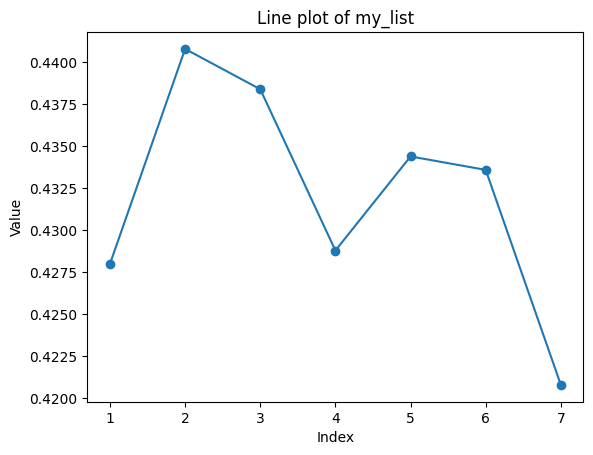

In [ ]:

import matplotlib.pyplot as plt

# 假设你有一个名为my_list的列表


# 生成x轴坐标
x_values = range(1, len(updated_cr_ls) + 1)

# 画折线图
plt.plot(x_values, updated_cr_ls, marker='o', linestyle='-')

# 添加标题和标签
plt.title('Line plot of my_list')
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图形
plt.show()